In [1]:
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil
import cmocean
import dask
from dask.distributed import Client, LocalCluster, Worker, progress
from dask_jobqueue import SLURMCluster
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from src.load_SAIdata import Cases
%matplotlib inline

## Computations

In [2]:
# from dask.distributed import Client

# client = Client("tcp://172.22.63.191:40579")
# client

cluster = LocalCluster(silence_logs=60, interface='ib0')
client = Client(cluster)

In [3]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 16
Total threads: 192,Total memory: 336.00 GiB
Status: running,Using processes: True
Comm: tcp://172.22.59.10:44519,Workers: 16
Dashboard: /proxy/8787/status,Total threads: 192
Started: Just now,Total memory: 336.00 GiB
Comm: tcp://172.22.59.10:40249,Total threads: 12
Dashboard: /proxy/42751/status,Memory: 21.00 GiB
Nanny: tcp://172.22.59.10:44395,


In [4]:
%%time

open_kwargs = dict(decode_times=True, decode_timedelta=True, chunks={'nlat':24})
exps = [case for case in Cases.cases if 'hres' in case]
ds = {exp: Cases(exp).select('ocn','h.nday1').open_mfdataset(**open_kwargs) for exp in exps}

CPU times: user 11.4 s, sys: 943 ms, total: 12.3 s
Wall time: 49.2 s


In [5]:
# center time
for exp in ds:
    ds[exp]['time'] = ds[exp].time - (ds[exp].time.values[1] - ds[exp].time.values[0])/2
    tslice = slice('2003','2007') if 'ref' in exp else slice('2093','2097')
    ds[exp] = ds[exp].sel(time=tslice)
    print(f"{exp}: {ds[exp].time.min().item()} - {ds[exp].time.max().item()} steps={ds[exp].time.size}")

hres.ref.1: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.2: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.3: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.4: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.5: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.ref.6: 2003-01-01 12:00:00 - 2007-12-31 12:00:00 steps=1825
hres.cnt.1: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.2: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.3: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.4: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.5: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.cnt.6: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.sai.1: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.sai.2: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.sai.3: 2093-01-01 12:00:00 - 2097-12-31 12:00:00 steps=1825
hres.sai.4: 2093-01-01 12

In [6]:
SST_tmean = []
for exp in ds:
    gb = ds[exp].SST.groupby('time.month')
    SST_tmean.append(gb.mean('time', keep_attrs=True).persist())

progress(SST_tmean[:], multi=False)

In [7]:
SSTref = xr.concat(SST_tmean[0:6], dim='ens', compat='override', join='exact', coords='minimal')
SSTcnt = xr.concat(SST_tmean[6:12], dim='ens', compat='override', join='exact', coords='minimal')
SSTsai = xr.concat(SST_tmean[12:18], dim='ens', compat='override', join='exact', coords='minimal')

SSTref = SSTref.mean('ens', keep_attrs=True)
SSTcnt = SSTcnt.mean('ens', keep_attrs=True)
SSTsai = SSTsai.mean('ens', keep_attrs=True)

SST = xr.concat([SSTref, SSTcnt, SSTsai], dim='exp', compat='override', join='exact', coords='minimal')
SST = SST.assign_coords({'exp':('exp',['ref','cnt','sai'])})
SST = SST.persist()

progress(SST, multi=False)

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/distributed/client.py:3383: UserWarning: Sending large graph of size 10.80 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


In [13]:
SST = SST.compute()

In [14]:
%%time
SST.to_netcdf("../data/SST.nc")

CPU times: user 77.9 ms, sys: 221 ms, total: 299 ms
Wall time: 326 ms


## Plotting

In [2]:
ds =  xr.open_dataset("../data/SST.nc")

# add cyclical point
ds = xr.concat((ds, ds.isel(nlon=0)), dim='nlon') 

# invalid points
mask = (ds.ULONG==-1) & (ds.ULAT==-1)

# remove sudden 360 deg jumps in longitude
ds.ULONG.data += 360 * ((ds.ULONG<0) & (ds.nlon>2500) & ~mask)
assert (abs(ds.ULONG.diff('nlon')) > 359).sum() == 0, "sudden jumps found in longitude"

/scratch-local/jasperdj.11193467/ipykernel_77510/1630603293.py:14: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x151bd31abf80>' will be ignored
  pcm.set_rasterized(True)
/scratch-local/jasperdj.11193467/ipykernel_77510/1630603293.py:23: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x151bda3cf770>' will be ignored
  pcm.set_rasterized(True)
/scratch-local/jasperdj.11193467/ipykernel_77510/1630603293.py:31: UserWarning: Rasterization of '<cartopy.mpl.contour.GeoContourSet object at 0x151bda3e3a40>' will be ignored
  pcm.set_rasterized(True)


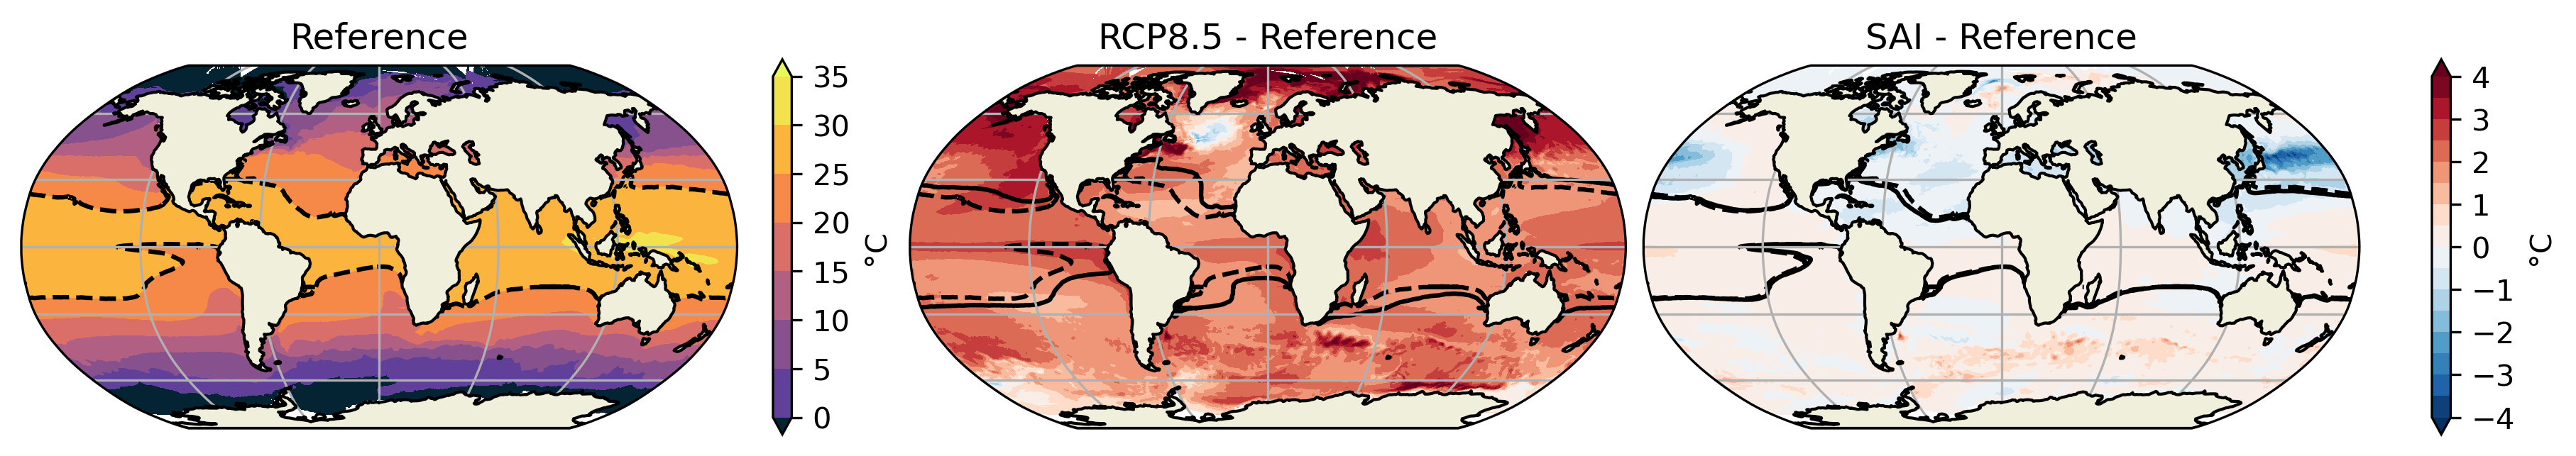

In [27]:
lons = ds.ULONG
lats = ds.ULAT
SST = ds.SST.where(~mask)

kwargs = dict(transform=ccrs.PlateCarree(), transform_first=True)

# for data, title in zip((SST.mean('month', keep_attrs=True), SST.sel(month=10), SST.sel(month=4)), ['annual','october','april']):
data = SST.mean('month')

fig,axs = plt.subplots(1,3, dpi=300, figsize=(12,4), layout='constrained', subplot_kw={'projection':ccrs.Robinson()})

ax=axs[0]
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=np.arange(0,36,5), extend='both', vmin=-10, cmap='cmo.thermal', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
cb = fig.colorbar(pcm, ax=axs[0], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')
ax.set_title('Reference')

ax = axs[1]
ddata = data.sel(exp='cnt') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='cnt'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('RCP8.5 - Reference')

ax = axs[2]
ddata = data.sel(exp='sai') - data.sel(exp='ref')
pcm = ax.contourf(lons, lats, ddata, levels=np.arange(-4,4.1,0.5), extend='both', cmap='RdBu_r', **kwargs)
pcm.set_rasterized(True)
ax.contour(lons, lats, data.sel(exp='ref'), levels=[25], colors='k', linestyles='--', **kwargs)
ax.contour(lons, lats, data.sel(exp='sai'), levels=[25], colors='k', linestyles='-', **kwargs)
ax.set_title('SAI - Reference')

cb = fig.colorbar(pcm, ax=axs[1:], shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')

for ax in axs.flatten():
    ax.gridlines()
    ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

fig.savefig('../figures/SST.pdf', bbox_inches='tight', transparent=True)
# fig.suptitle(title)

TypeError: 'QuadContourSet' object is not subscriptable

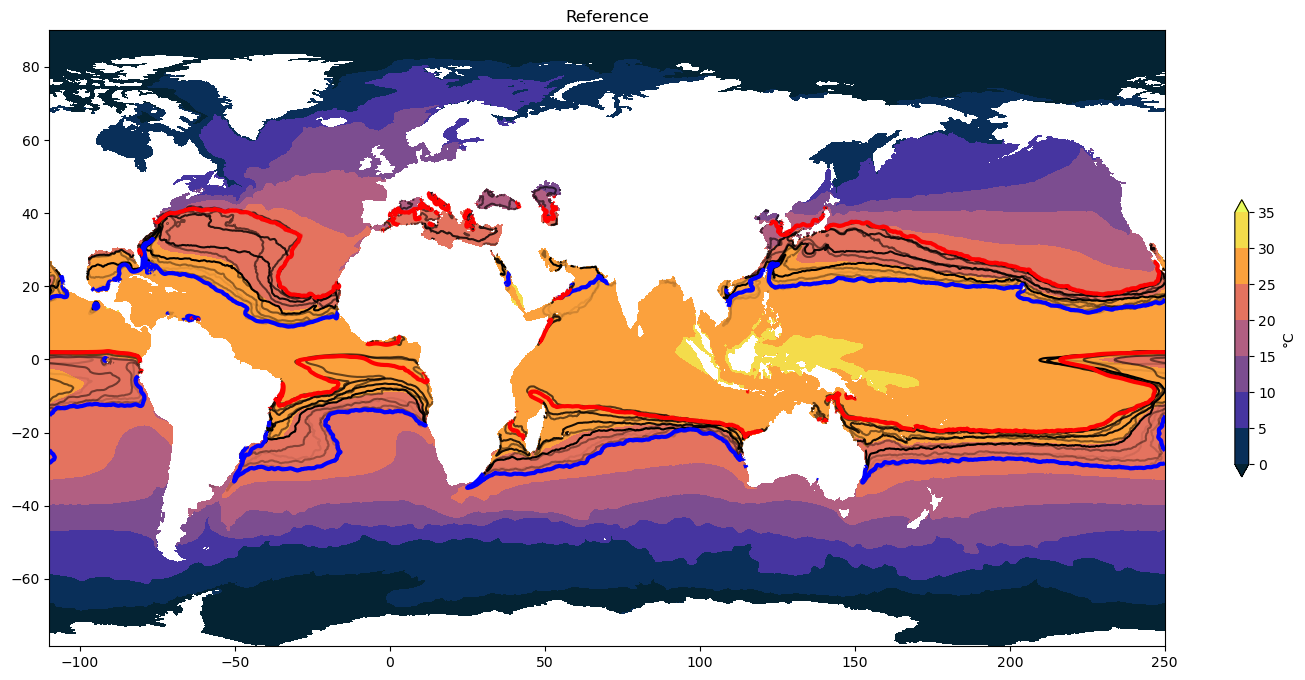

In [4]:
lons = ds.ULONG
lats = ds.ULAT
SST = ds.SST.where(~mask)
data = SST.mean('month')
kwargs = {}

fig = plt.figure(figsize=(18,8))
ax=plt.axes(projection=None)
pcm = ax.contourf(lons, lats, data.sel(exp='ref'), levels=range(0,36,5), extend='both', cmap='cmo.thermal', **kwargs)
for mon in SST.month:
    data = SST.sel(month=mon, exp='ref')
    ax.contour(lons, lats, data, levels=[25], alpha=mon.item()/12, colors='k', linestyles='-', **kwargs)
cs1= ax.contour(lons, lats, SST.sel(month=3, exp='ref'), levels=[25], colors='b', linewidths=3, **kwargs)
cs2 = ax.contour(lons, lats, SST.sel(month=9, exp='ref'), levels=[25], colors='r', linewidths=3, **kwargs)
cb = fig.colorbar(pcm, ax=ax, shrink=0.45, orientation='vertical')
cb.ax.set_ylabel('°C')
ax.set_title('Reference')
ax.legend([cs1[0],cs2[0]], ['March', 'September'])
#ax.gridlines()
#ax.add_feature(cfeature.LAND, zorder=2, edgecolor='black')

In [28]:
import json

with open('segments.txt','w') as f:
    allsegs_list = {str(c): [list(s) for s in segs] for c,segs in zip(cs.levels,allsegs)}
    json.dump(allsegs_list, f)

with open('segments.txt','r') as f:
    allsegs_read = json.load(f)

-rw-r----- 1 jasperdj jasperdj 674K Apr 15 16:47 ../figures/SST.pdf
